# Categorical/Softmax Regression/Classification of IRIS data set

- For ML estimation, see Logistic Regression in [Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/)
    - page 144 of the pdf

In [1]:
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
import jax
import jax.random as random
import jax.numpy as jnp
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns;
#sns.set_style("darkgrid");
plt.rcParams['figure.dpi'] = 100
# plt.rcParams.update({"grid.linewidth":0.5, "grid.alpha":0.5})
# plt.style.use("dark_background")

In [2]:
def medstat(v):
    v = v.sort()
    med = v[len(v)//2]
    mad = np.median(np.abs(v-med))
    mad_sd = 1.483 * mad
    return med, mad_sd

def print_abs_summary(d, keys=None):
    print(' Med MAD_SD')
    for k, v in d.items():
        if (keys is None) or (k in keys):
            med, mad_sd = medstat(v)
            print(f'{k:7} {med:+5.3f} {mad_sd:+5.3f}')

In [3]:
rngkey = random.PRNGKey(0)
rngkey, subkey = jax.random.split(rngkey)
rngkey

array([4146024105,  967050713], dtype=uint32)

In [4]:
iris = sns.load_dataset('iris')
iris.head(3)

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa


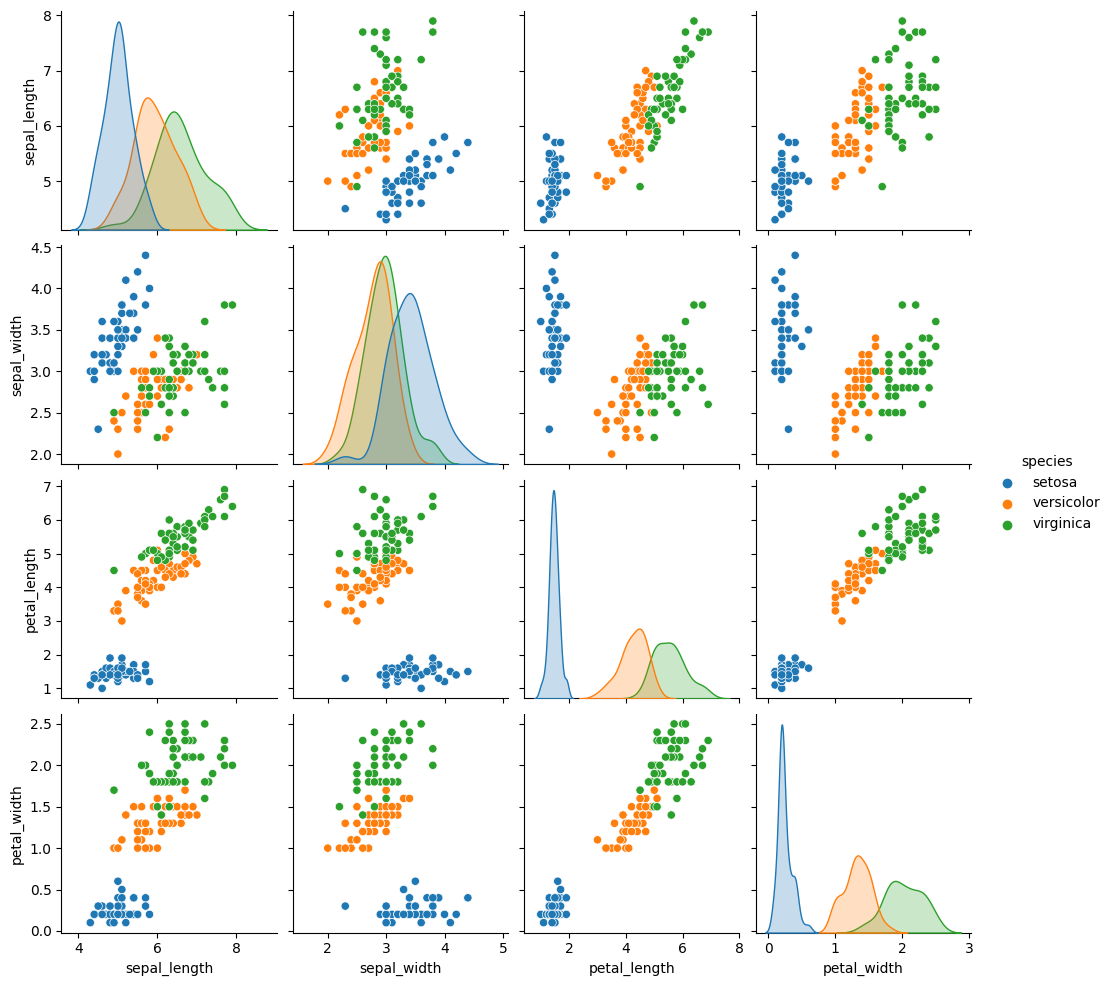

In [5]:
sns.pairplot(iris, hue='species');

In [6]:
feature_names = iris.columns[:-1]
print('feature_names: ', feature_names)
x = iris[feature_names].values
x[:3]

feature_names:  Index(['sepal_length', 'sepal_width', 'petal_length', 'petal_width'], dtype='object')


array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2]])

In [7]:
iris['species'] = iris['species'].astype('category')
iris.head(3)

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa


In [8]:
y = iris.species.cat.codes.values
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int8)

In [9]:
def model(x, y=None):
    # simple linear model
    a = numpyro.sample('a', dist.Normal(0, 10), sample_shape=(3,))  # bias/intercept, three species
    b = numpyro.sample('b', dist.Normal(0, 10), sample_shape=(4,3))
#    print(b.shape)
    
    with numpyro.plate(f'y:{x.shape[0]}', size=x.shape[0]):  ## observation
        t = a + jnp.dot(x, b)
        probs = numpyro.deterministic('probs', jax.nn.softmax(t))  ## probs by softmax
        obs = numpyro.sample('y', dist.Categorical(probs=probs), obs=y)       
#        print(t.shape, obs.shape, probs.shape)

The shape is similar to a small scale neural network. Try to draw a figure to find analogy.

## MCMC Inference

In [10]:
def mcmcinf(model, args):
    # args: dict for model input arguments
    kernel = NUTS(model)
    mcmc = MCMC(kernel, num_warmup=1000, num_samples=10000, num_chains=1)
    #
    mcmc.run(rngkey, **args)
    mcmc.print_summary(exclude_deterministic=True, prob=.8)
    return mcmc

In [11]:
args = dict(x=x, y=y)
mcmc = mcmcinf(model, args)

sample: 100%|██████████| 11000/11000 [00:29<00:00, 372.93it/s, 266 steps of size 8.95e-03. acc. prob=0.89]



                mean       std    median     10.0%     90.0%     n_eff     r_hat
      a[0]      2.86      9.86      3.16    -10.08     14.95    920.04      1.00
      a[1]      8.16      8.00      8.26     -2.73     17.97    827.59      1.00
      a[2]    -10.70      7.82    -10.85    -20.57     -0.86    785.89      1.00
    b[0,0]      3.14      6.79      3.08     -5.86     11.31    663.08      1.00
    b[0,1]     -0.10      6.28      0.04     -7.64      8.69    469.63      1.00
    b[0,2]     -3.50      6.28     -3.32    -11.30      4.73    479.12      1.00
    b[1,0]      4.95      7.21      4.98     -3.43     15.20    478.16      1.00
    b[1,1]     -1.11      6.36     -1.14     -9.06      7.56    552.30      1.00
    b[1,2]     -5.74      6.45     -5.81    -13.92      2.60    577.29      1.00
    b[2,0]     -8.87      6.84     -8.77    -17.29      0.30    649.87      1.00
    b[2,1]      1.47      6.28      1.42     -6.49      9.63    383.58      1.00
    b[2,2]      8.51      6

In [12]:
s = mcmc.get_samples()
s

{'a': DeviceArray([[ -4.2118998 ,  13.509837  ,  -0.21761106],
              [-14.707395  ,   7.6090684 ,  -2.0873942 ],
              [-14.313697  ,   9.989566  ,  -6.4648976 ],
              ...,
              [  4.3664374 ,  23.851803  ,  -0.4553661 ],
              [  6.664572  ,  20.302874  ,  -6.2082095 ],
              [ 21.105547  ,  14.032392  ,  -6.2909465 ]], dtype=float32),
 'b': DeviceArray([[[  1.4689673 ,  -2.0475914 ,  -3.6601498 ],
               [  1.1439523 ,  -8.215616  , -16.31053   ],
               [ -8.969989  ,   5.631114  ,   9.529733  ],
               [  4.546058  ,  -9.603322  ,   7.201687  ]],
 
              [[ -2.7993774 ,  -4.1416593 , -10.637366  ],
               [  8.681515  ,  -4.728204  ,  -5.6344247 ],
               [ -7.6787395 ,   0.2005359 ,   9.070593  ],
               [ -1.585606  ,  -1.0126286 ,   4.487161  ]],
 
              [[ -2.2285187 ,  -5.6195803 , -13.4192095 ],
               [  8.114235  ,  -1.3047528 ,  -3.8162503 ],
          

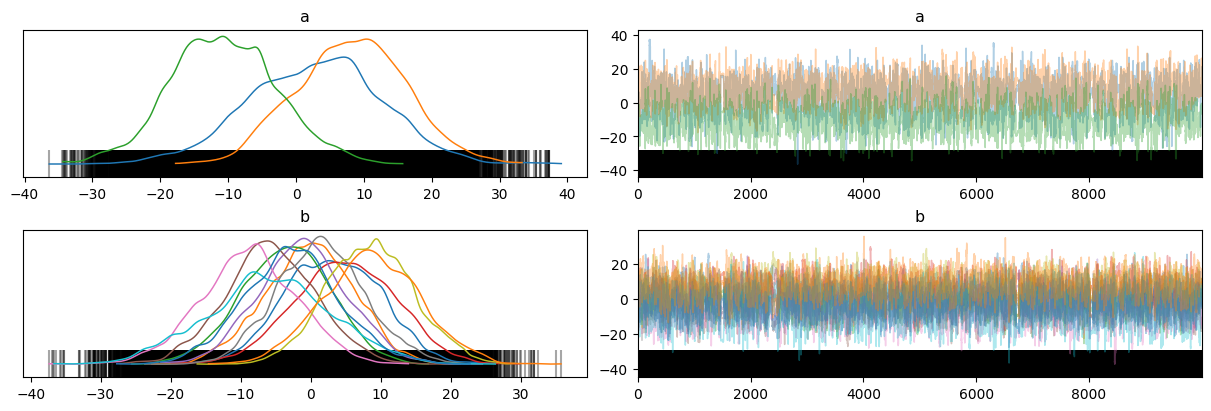

In [13]:
import arviz
azdata = arviz.from_numpyro(mcmc)
arviz.plot_trace(azdata, var_names=['a', 'b']);

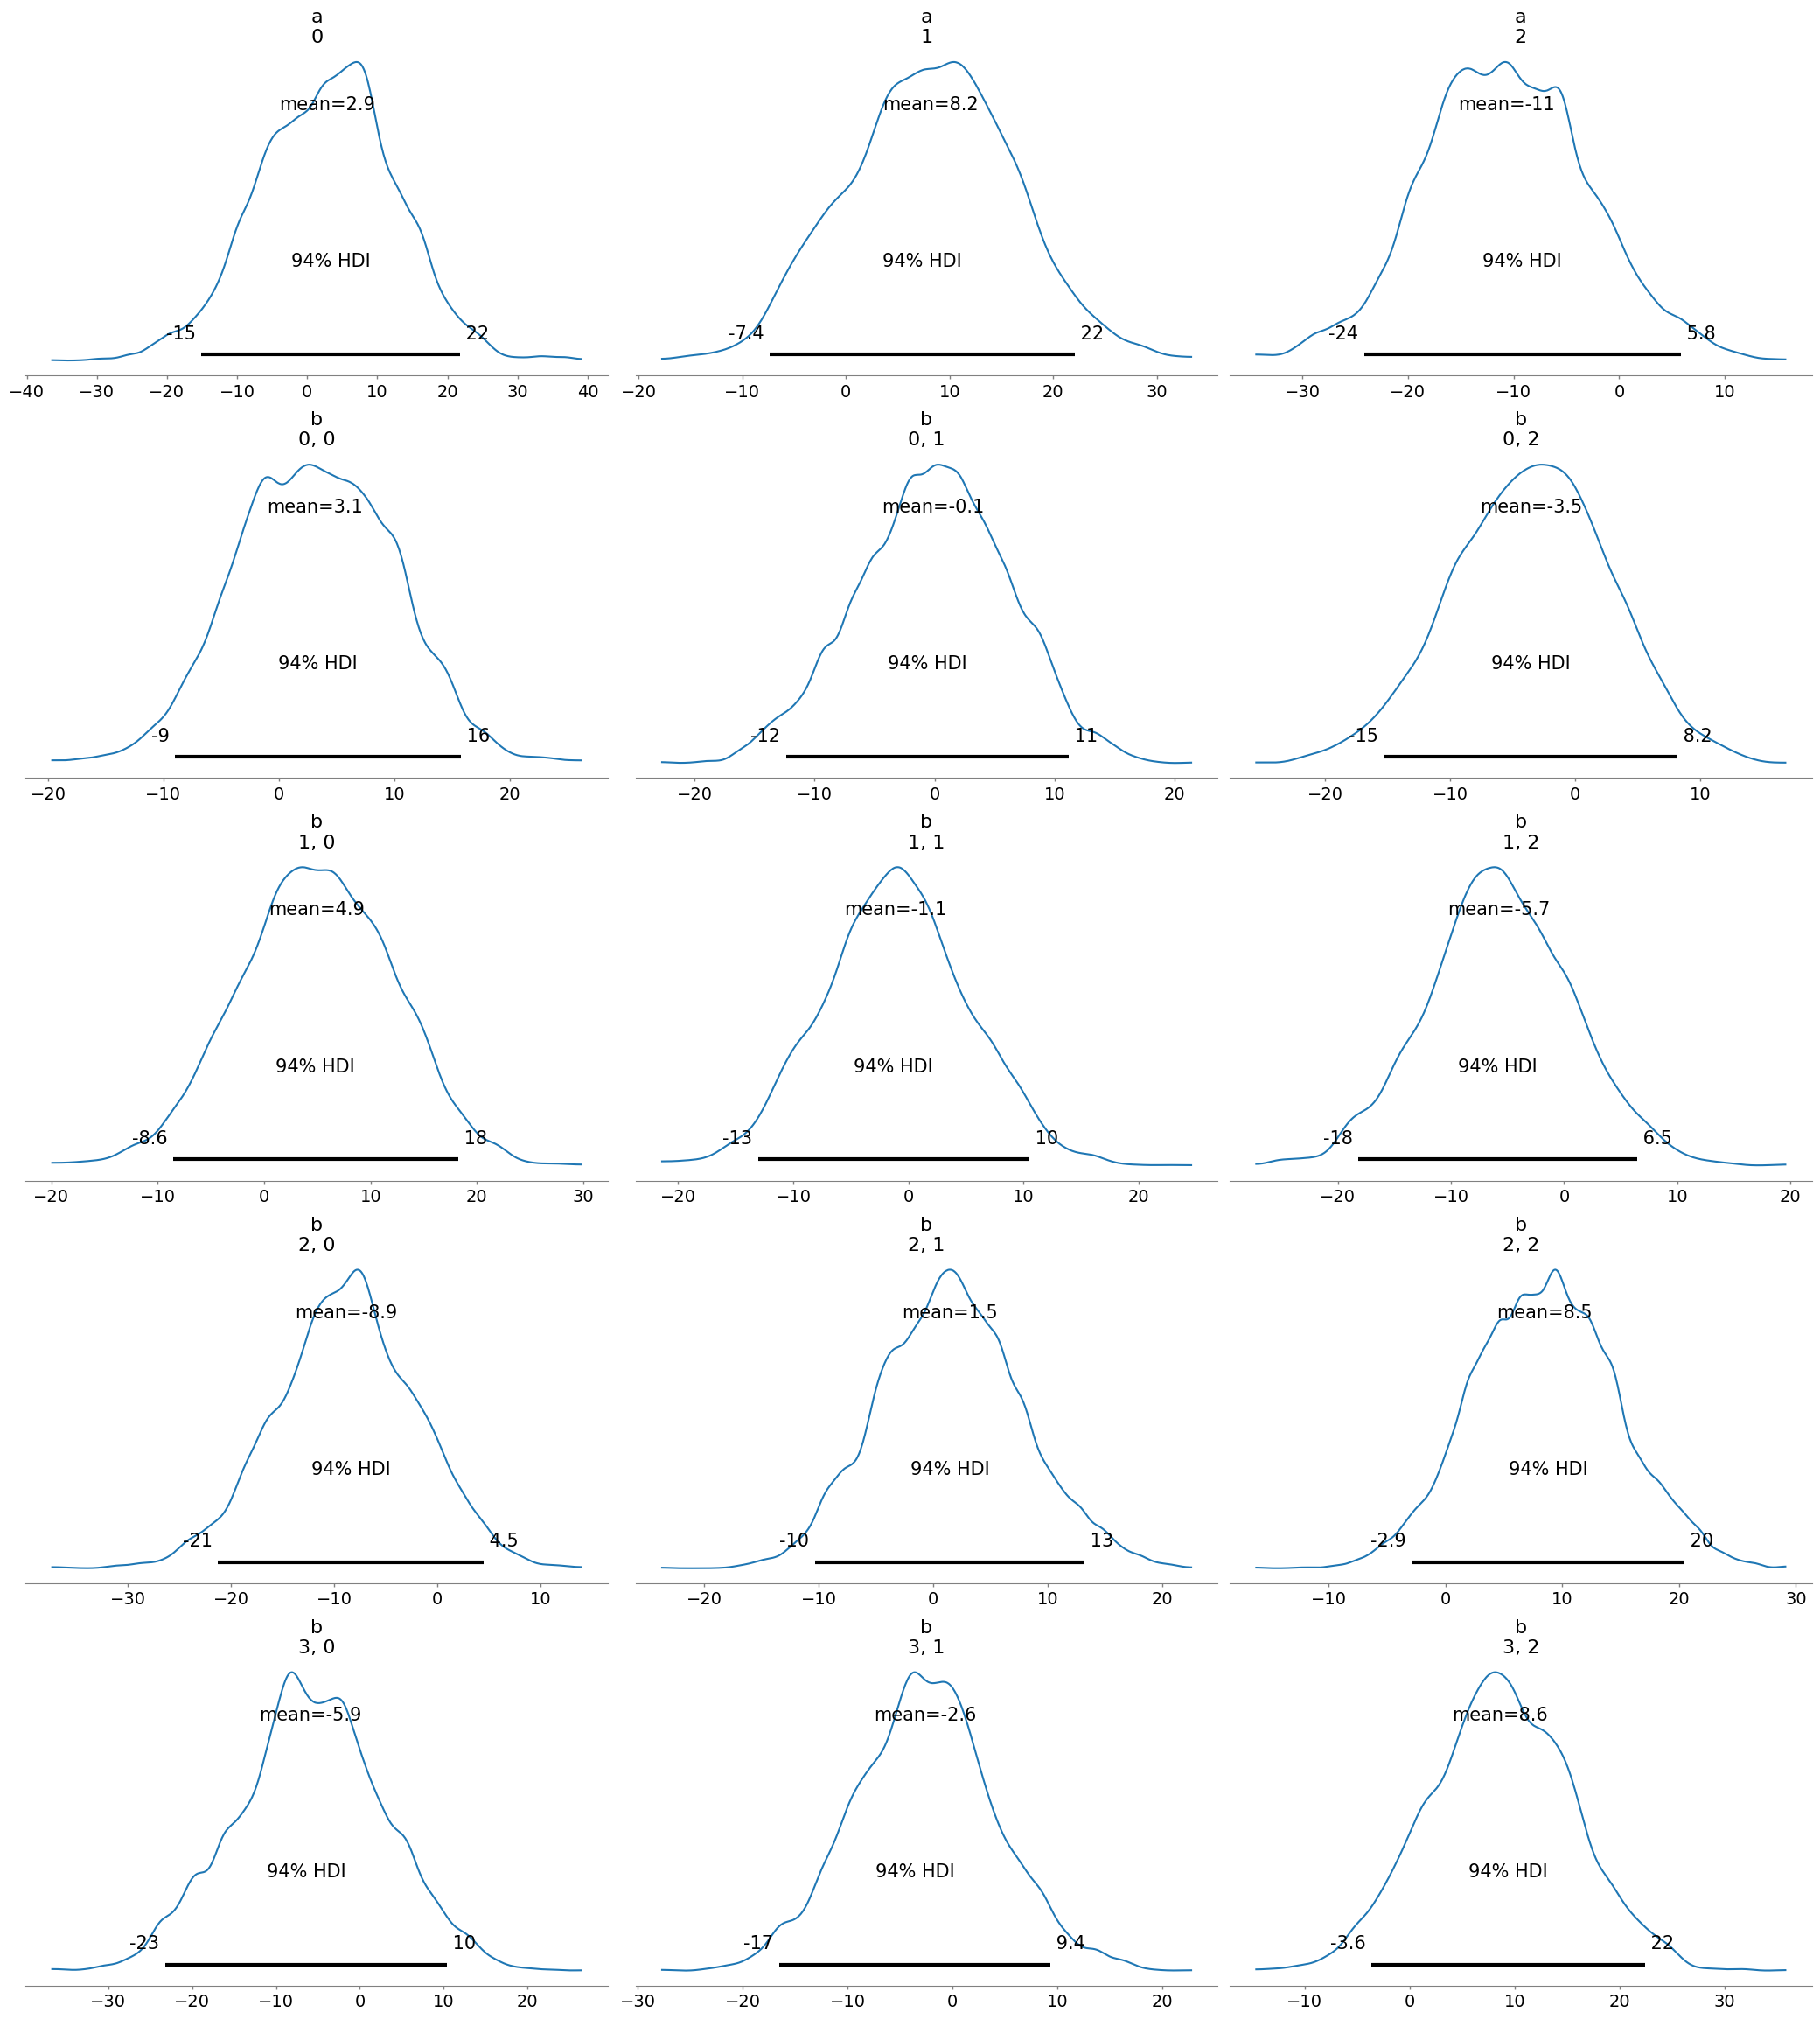

In [14]:
arviz.plot_posterior(azdata, var_names=['a', 'b']);

In [15]:
print(feature_names)

Index(['sepal_length', 'sepal_width', 'petal_length', 'petal_width'], dtype='object')


## Prediction

In [16]:
predictive = Predictive(model, posterior_samples=mcmc.get_samples())

In [17]:
d = x[0:1, :]  # the first data
d

array([[5.1, 3.5, 1.4, 0.2]])

In [18]:
pred = predictive(rng_key=jax.random.PRNGKey(0), x=d)

In [19]:
pred

{'probs': DeviceArray([[[9.9999976e-01, 2.1352038e-07, 2.0969195e-25]],
 
              [[1.0000000e+00, 1.5002893e-09, 1.1776766e-23]],
 
              [[9.9999988e-01, 1.4103043e-07, 2.6896813e-28]],
 
              ...,
 
              [[1.0000000e+00, 1.0201548e-08, 2.5518529e-25]],
 
              [[9.9994969e-01, 5.0361199e-05, 1.7689636e-26]],
 
              [[1.0000000e+00, 1.0303836e-13, 1.1725972e-31]]],            dtype=float32),
 'y': DeviceArray([[0],
              [0],
              [0],
              ...,
              [0],
              [0],
              [0]], dtype=int32)}

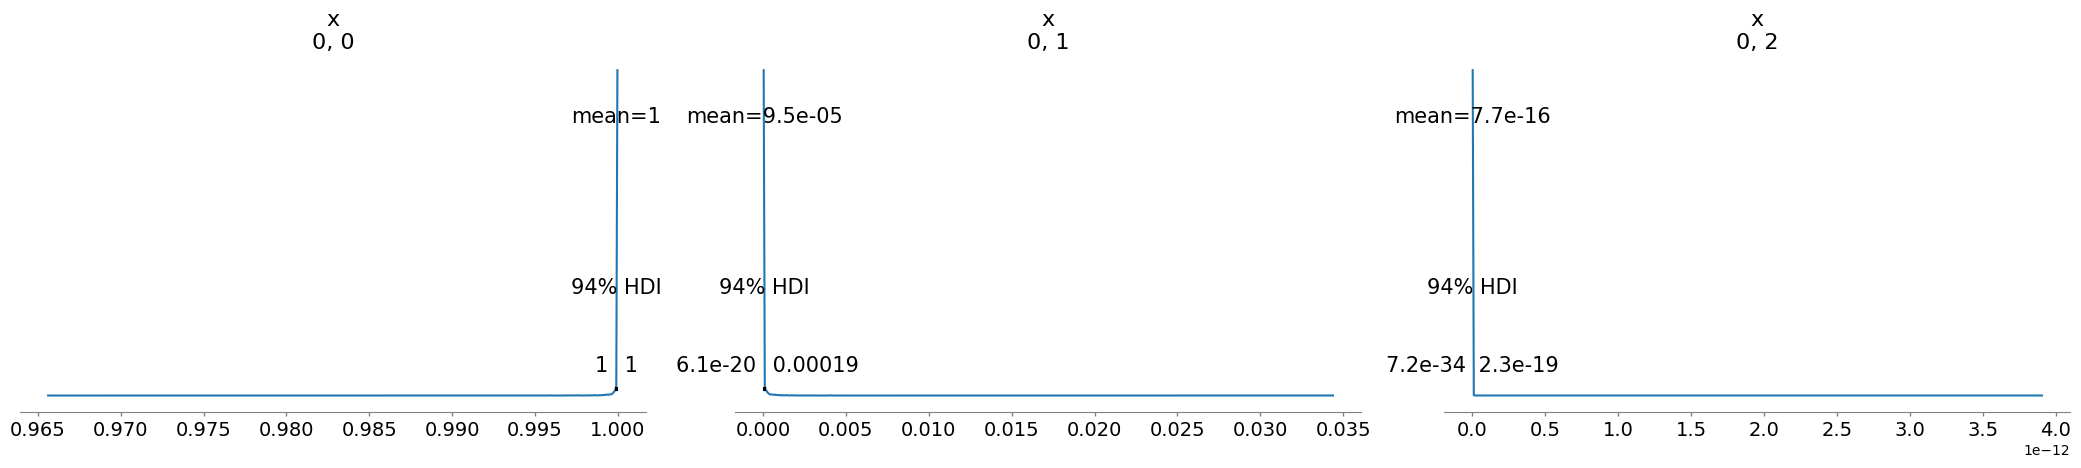

In [20]:
arviz.plot_posterior(np.array( jnp.expand_dims(pred['probs'], 0)) );

### another data

In [21]:
d = x[100, :]  # 
d

array([6.3, 3.3, 6. , 2.5])

In [22]:
pred = predictive(rng_key=jax.random.PRNGKey(0), x=d)

In [23]:
pred

{'probs': DeviceArray([[1.6782152e-14, 3.7196975e-07, 9.9999964e-01],
              [1.7510338e-14, 1.5771856e-06, 9.9999845e-01],
              [4.1619541e-20, 1.8059334e-08, 1.0000000e+00],
              ...,
              [6.8296695e-19, 5.3380641e-06, 9.9999464e-01],
              [1.4555473e-14, 1.0120378e-09, 1.0000000e+00],
              [3.1118630e-18, 2.0609744e-07, 9.9999976e-01]],            dtype=float32),
 'y': DeviceArray([[2, 2, 2, 2],
              [2, 2, 2, 2],
              [2, 2, 2, 2],
              ...,
              [2, 2, 2, 2],
              [2, 2, 2, 2],
              [2, 2, 2, 2]], dtype=int32)}

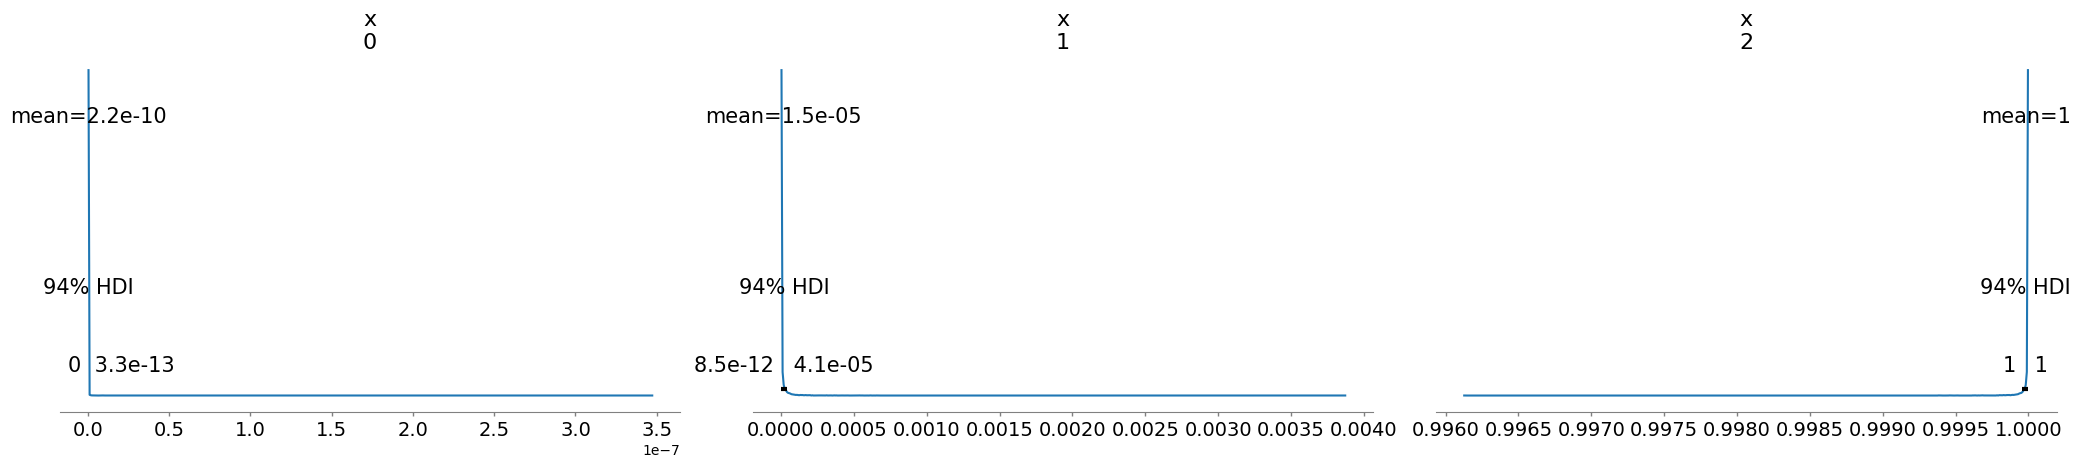

In [24]:
arviz.plot_posterior(np.array( jnp.expand_dims(pred['probs'], 0)) );

# Categorical Regression using Two Features only
- Good to visualize the feature space classifcation (feature map)
    - probabilistic feature map
    - hard threshold
- See the entropy plot
    - uncertain area corresponds to high values of entropy
    

In [25]:
def model_2(x, y=None):
    # simple linear model
    a = numpyro.sample('a', dist.Normal(0, 10), sample_shape=(3,))  # bias/intercept, three species
    b = numpyro.sample('b', dist.Normal(0, 10), sample_shape=(2,3))
#    print(b.shape)
    
    with numpyro.plate(f'y:{x.shape[0]}', size=x.shape[0]):  ## observation
        t = a + jnp.dot(x, b)
        probs = numpyro.deterministic('probs', jax.nn.softmax(t))  ## probs by softmax
        obs = numpyro.sample('y', dist.Categorical(probs=probs), obs=y)       
#        print(t.shape, obs.shape, probs.shape)

In [26]:
args = dict(x=x[:,:2], y=y)  # use (sepal length, sepal width)
mcmc = mcmcinf(model_2, args)

sample: 100%|██████████| 11000/11000 [01:20<00:00, 137.34it/s, 1023 steps of size 3.39e-03. acc. prob=0.96]



                mean       std    median     10.0%     90.0%     n_eff     r_hat
      a[0]     13.93      7.71     13.88      3.41     23.09   5387.47      1.00
      a[1]     -0.66      6.40     -0.68     -9.26      7.07   3940.87      1.00
      a[2]    -13.11      6.53    -13.13    -22.35     -5.56   3953.84      1.00
    b[0,0]     -7.47      6.00     -7.45    -14.80      0.57   3190.95      1.00
    b[0,1]      2.91      5.82      2.88     -5.01      9.92   3180.50      1.00
    b[0,2]      4.74      5.83      4.72     -3.32     11.60   3177.64      1.00
    b[1,0]      8.95      6.38      8.93      0.77     16.99   2924.69      1.00
    b[1,1]     -4.55      6.05     -4.60    -11.84      3.52   2579.65      1.00
    b[1,2]     -4.19      6.04     -4.28    -11.60      3.78   2604.67      1.00

Number of divergences: 1


In [27]:
s = mcmc.get_samples()
s.keys()

dict_keys(['a', 'b', 'probs'])

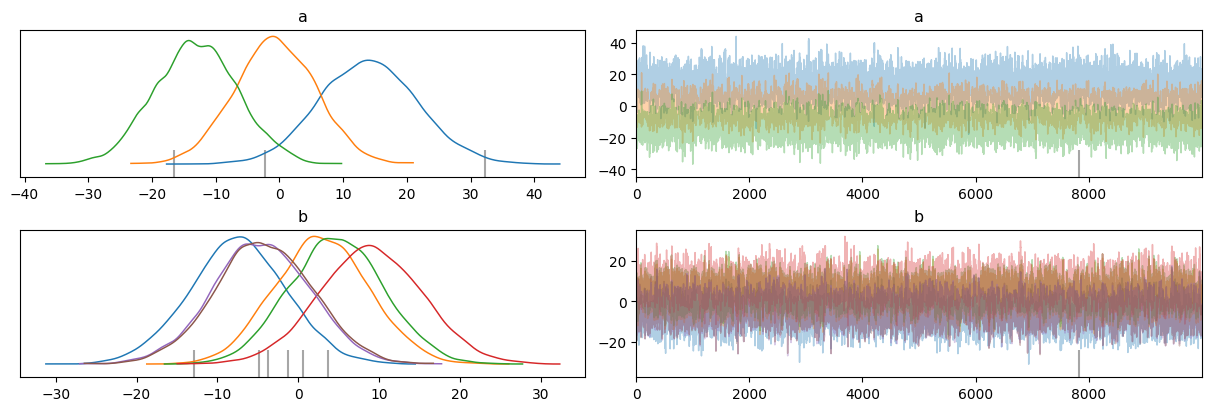

In [28]:
import arviz
azdata = arviz.from_numpyro(mcmc)
arviz.plot_trace(azdata, var_names=['a', 'b']);

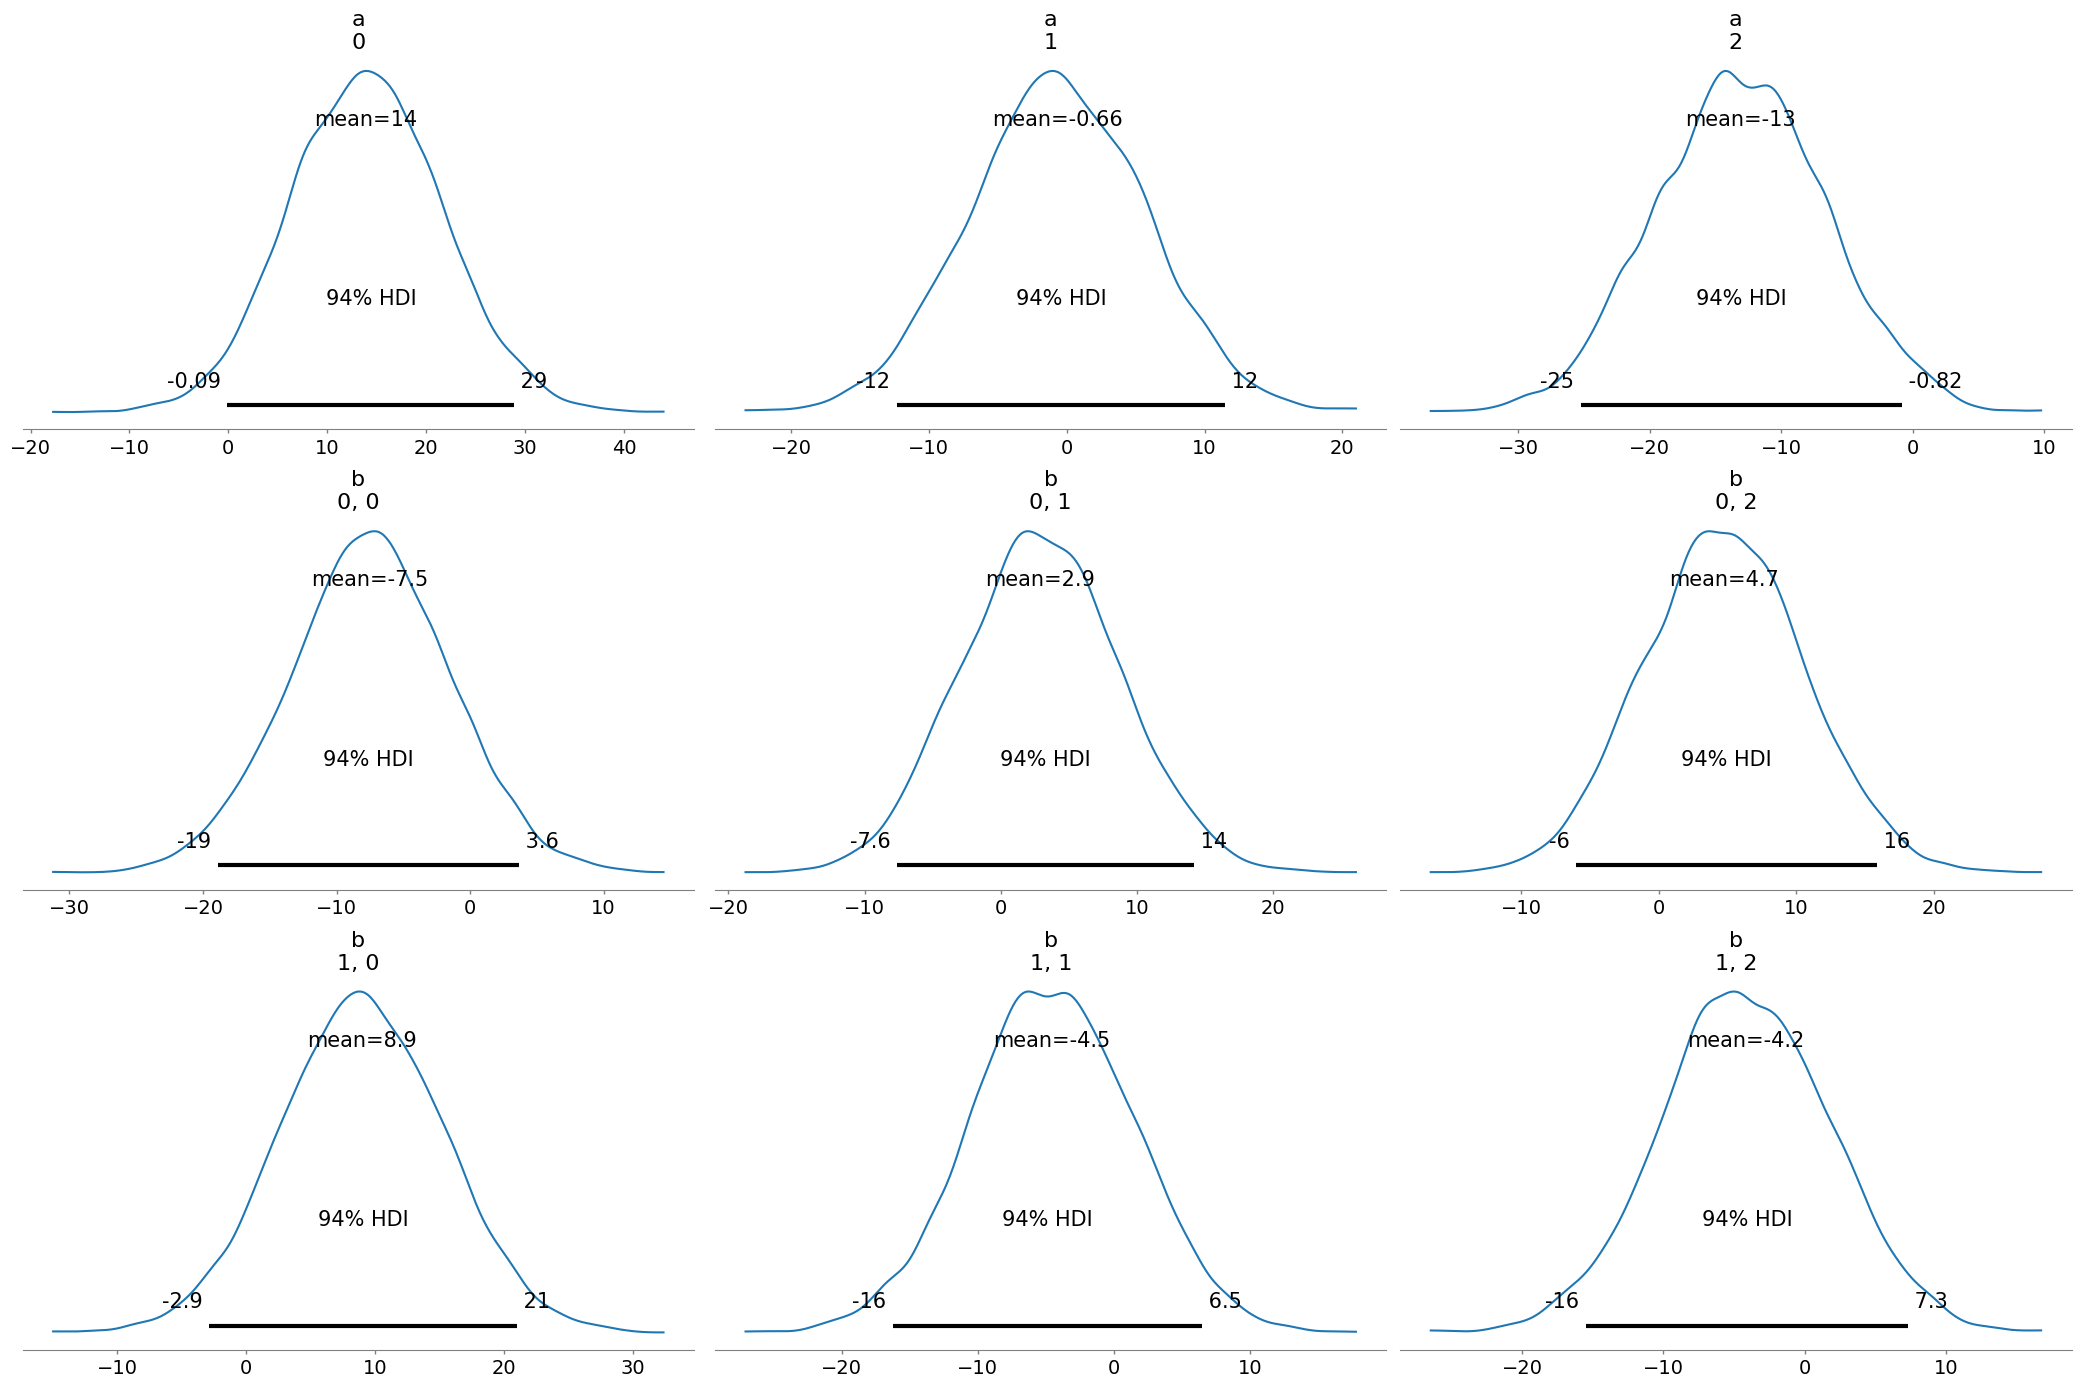

In [29]:
arviz.plot_posterior(azdata, var_names=['a', 'b']);

In [30]:
print(feature_names)

Index(['sepal_length', 'sepal_width', 'petal_length', 'petal_width'], dtype='object')


## Prediction

In [31]:
predictive = Predictive(model_2, posterior_samples=mcmc.get_samples())

In [32]:
d = x[0, :2]  # the first data
d

array([5.1, 3.5])

In [33]:
pred = predictive(rng_key=jax.random.PRNGKey(0), x=d)

In [34]:
pred

{'probs': DeviceArray([[9.9998248e-01, 1.4128605e-05, 3.3181329e-06],
              [9.9994051e-01, 4.2912179e-05, 1.6520753e-05],
              [9.9999976e-01, 1.8942818e-07, 1.0566412e-08],
              ...,
              [9.9977618e-01, 2.0069176e-04, 2.3114762e-05],
              [9.9900889e-01, 8.4168074e-04, 1.4933702e-04],
              [9.9998736e-01, 1.1359227e-05, 1.2549339e-06]],            dtype=float32),
 'y': DeviceArray([[0, 0],
              [0, 0],
              [0, 0],
              ...,
              [0, 0],
              [0, 0],
              [0, 0]], dtype=int32)}

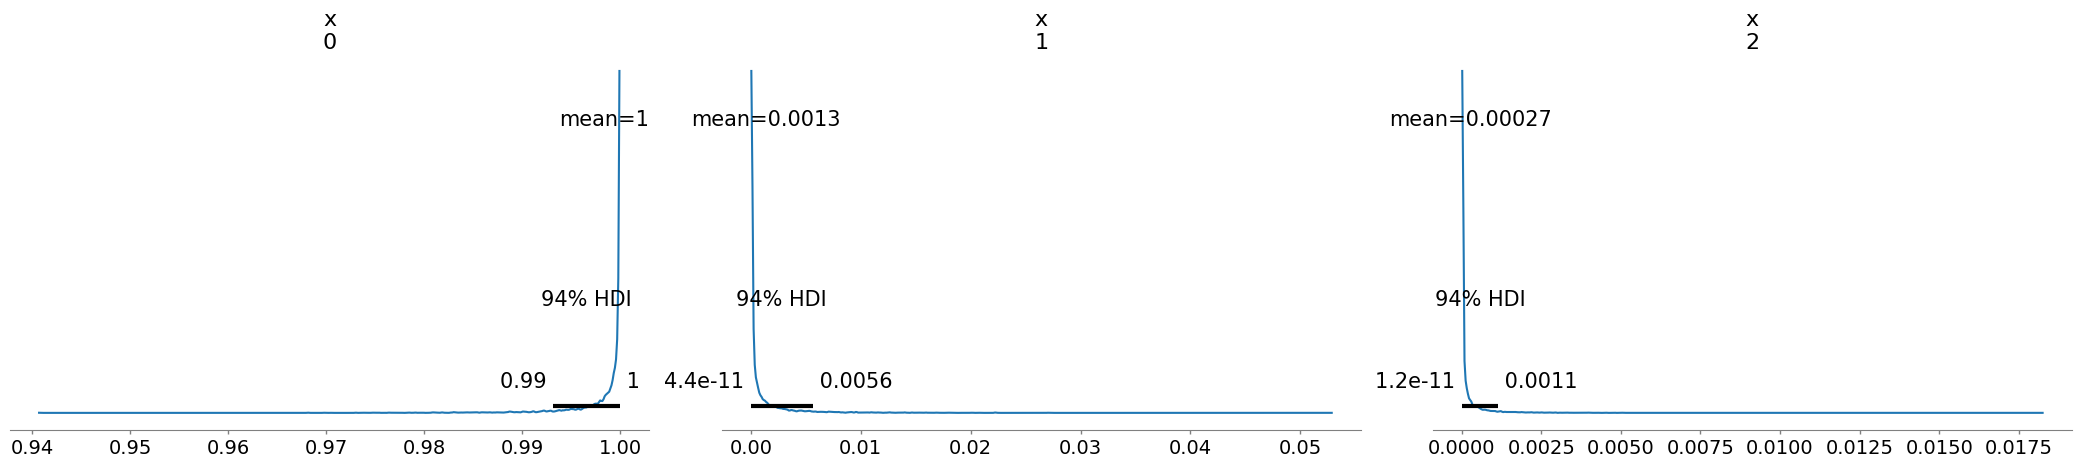

In [35]:
arviz.plot_posterior(np.array( jnp.expand_dims(pred['probs'], 0)) );

### Create a feature map

In [37]:
probs = pred['probs']
print(probs[0])

[9.9998248e-01 1.4128605e-05 3.3181329e-06]


In [38]:
m, M = x.min(0), x.max(0); m, M

(array([4.3, 2. , 1. , 0.1]), array([7.9, 4.4, 6.9, 2.5]))

Grid generation.

- Use `np.meshgrid`: https://numpy.org/doc/stable/reference/generated/numpy.meshgrid.html
- or just random sample

(15000, 2)


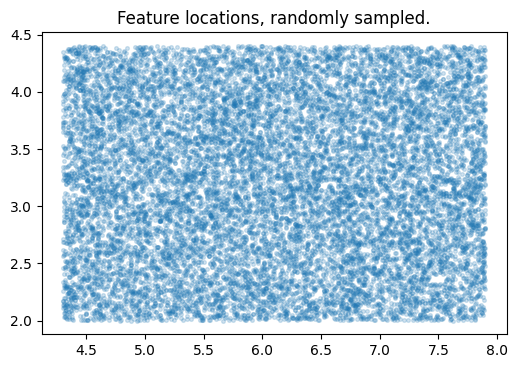

In [39]:
rng = np.random.default_rng(0)
size = 15000
xr = np.c_[rng.uniform(m[0], M[0], size=size), rng.uniform(m[1], M[1], size=size)]
print(xr.shape)
plt.scatter(xr[:,0], xr[:,1], alpha=.2, s=7); plt.title('Feature locations, randomly sampled.');

In [40]:
pr = predictive(rng_key=jax.random.PRNGKey(0), x=xr)['probs']

In [41]:
pr.shape

(10000, 15000, 3)

Let's make a mean probability

In [42]:
mp = pr.mean(0); mp.shape, mp[:2]

((15000, 3),
 DeviceArray([[4.4244476e-07, 3.8398033e-01, 6.1601919e-01],
              [1.4178049e-02, 8.4458047e-01, 1.4124149e-01]],            dtype=float32))

In [43]:
classid = np.argmax(mp, axis=1)
classid

DeviceArray([2, 1, 0, ..., 2, 0, 0], dtype=int32)

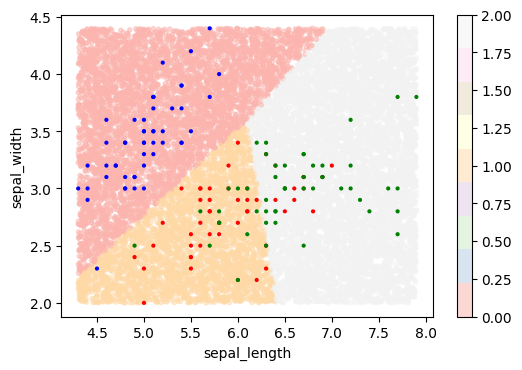

In [44]:
plt.scatter(xr[:,0], xr[:,1], alpha=.51, s=9, cmap='Pastel1', c=classid);
plt.colorbar();
plt.xlabel(feature_names[0]); plt.ylabel(feature_names[1]);

colors = np.array(['b', 'r', 'g'])
plt.scatter(x[:,0], x[:,1], s=4, c=colors[y]);

Entropy Map

In [45]:
def entropy(probs):
#    e = -np.sum([p * np.log(p) for p in probs])
    m = -np.log(probs) * probs
    e = m.sum(axis=1 if len(m.shape) >= 2 else 0)
    return e

In [46]:
entropy([0.98, 0.01, 0.01]), entropy([1/2, 1/2]), entropy([1/3, 1/3, 1/3]), entropy([1/10 for _ in range(10)])

(0.11190205689093088,
 0.6931471805599453,
 1.0986122886681096,
 2.3025850929940455)

In [47]:
probs = pred['probs']
print(probs[0])
entropy(probs[0])

[9.9998248e-01 1.4128605e-05 3.3181329e-06]


DeviceArray(0.00021716, dtype=float32)

In [48]:
ent = entropy(mp)
ent.shape, ent

((15000,),
 DeviceArray([6.6598582e-01, 4.7945490e-01, 8.3954219e-06, ...,
              5.7439023e-01, 2.5839098e-03, 7.7752697e-01], dtype=float32))

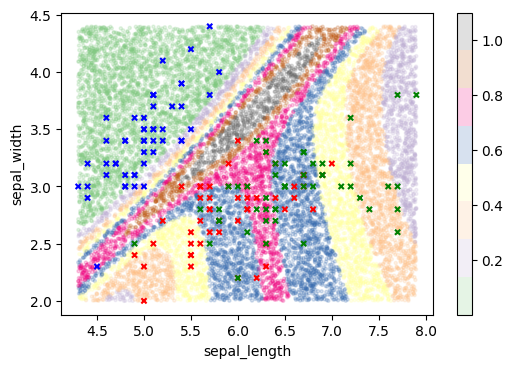

In [49]:
colors = np.array(['b', 'r', 'g'])
plt.scatter(xr[:,0], xr[:,1], alpha=.2, s=5, cmap='Accent', c=ent);  # entropy map
plt.colorbar();
plt.scatter(x[:,0], x[:,1], s=14, c=colors[y], marker='x')  # training data
plt.xlabel(feature_names[0]); plt.ylabel(feature_names[1]);

# Apply Data Normalization!